# Libraries

In [ ]:
# General libraries
import pandas as pd # Handling csv data
import pickle as pkl # Handle pkl data
import numpy as np # Numerical operations
print('\nCurrent Numpy version: {}'.format(np.__version__))
from tqdm import tqdm # Progress bar
import time # Measure processing time
from google.colab import drive # Connect to Google Drive
import warnings
import datetime

# Plotting
import seaborn as sn
import matplotlib
import matplotlib.pyplot as plt
print('\nCurrent matplotlib version: {}'.format(matplotlib.__version__))
from matplotlib.pyplot import cm # Colors for loss plot
%matplotlib inline

# Reading and displaying images
from skimage.io import imread
from skimage.transform import resize

import sklearn
print('\nCurrent sklearn version: {}'.format(sklearn.__version__))

# Splitting dataset
from sklearn.model_selection import train_test_split
# Creating k-fold cross validation sets
from sklearn.model_selection import KFold

# Evaluating the model
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# PyTorch libraries and modules
!pip install torch torchvision torchaudio
import torch
print ("\nCurrent PyTorch version is: ", torch.__version__)
from torch.autograd import Variable

# Network architecture
import torch.nn as nn
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
# Optimizers
from torch.optim import Adam, SGD, RMSprop
from torch.utils.data import Dataset, DataLoader
# Torchvision for pre-trained models
from torchvision import models
# For normalizing the spectrograms 
from torchvision import transforms


from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

!pip install transformers
!pip install sentencepiece # needed for XLNet
import transformers
print ("\nCurrent transformers version is: ", transformers.__version__)
# XLNet 
from transformers import XLNetTokenizer, XLNetForSequenceClassification, XLNetModel, XLNetConfig
# BERT
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, BertModel
# Utils
from transformers import AdamW, get_linear_schedule_with_warmup

# Padding/Truncating sequence to MAX_LEN
from keras.preprocessing.sequence import pad_sequences

# Tensorflow for GPU access
import tensorflow as tf
print ("\nCurrent TensorFlow version is: ", tf.__version__)

print('\nImporting libraries completed!')

# Helper Functions

In [ ]:
# Loading data from pkl-files
def load_pkl_data(pkl_dir):
  t_start = time.time()
  print('\nLoading data...')

  with open(pkl_dir, "rb") as f:
    try:
      data = pkl.load(f)
      print('\nData loaded successfully from \n{}!'.format(pkl_dir))
      print('\nNumber of data entries: {}'.format(len(data)))
    except Exception as e:
      print(e)

  t_end = time.time()
  t_elapsed = t_end - t_start
  print('\nTime elapsed: {} seconds.'.format(np.round(t_elapsed,2)))

  return data


# Creating unique folder for storing the model and metrics 
def create_model_folder_name(dataset_name,saved_models_path):
  currentDT = datetime.datetime.now()
  folder_name = 'LyricsNet{}_{}'.format(dataset_name,currentDT.strftime("%Y%m%d_%H-%M-%S"))

  if not os.path.isdir(saved_models_path+folder_name):
    os.mkdir(saved_models_path+folder_name)
  else:
    warnings.warn('Folder {} already exists!'.format(saved_models_path+folder_name))
  
  return folder_name


# Defines a custom Log-file to keep track of actions
class Logger():
  def __init__(self):
    self.logs = {}

  def add(self,key,value):
    self.logs[str(key)] = value

  def __getitem__(self, key):
    entry = self.logs[key]
    return entry

  def save_log(self,path):
    longest_key = max(len(key) for key in self.logs)
    with open('{}Log_File.txt'.format(path), 'w') as f:
      f.write('{:=^60}\n\n'.format(' LOG FILE '))
      for key in self.logs:
        f.write('{:>{}}: {}\n\n'.format(str(key),longest_key,str(self.logs[key])))
      f.write('{:=^60}\n\n'.format(' END OF LOG '))


# Returns average loss for each training epoch (Palanisamy et al., 2020)
class RunningAverage():
	def __init__(self):
		self.total = 0
		self.steps = 0

	def update(self, loss):
		self.total += loss
		self.steps += 1

	def __call__(self):
		return (self.total/float(self.steps))

In [ ]:
# Set the device to the available GPU from Google Colab
def get_GPU_device():
  # Get the GPU device name.
  device_name = tf.test.gpu_device_name()

  GPU_name = "N/A"

  if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
  else:
    print('GPU device not found.')
    print('Maybe check if GPU is available for this notebook:')
    print('Edit ==> Notebook-Preferences ==> Hardware Acceleration ==> choose GPU!')

  # Check if GPU is available
  if torch.cuda.is_available():    
  
    device = torch.device("cuda")
    print('\nThere are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU: {}\n'.format(torch.cuda.get_device_name(0)))
    GPU_name = str(torch.cuda.get_device_name(0))

  else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    
  return device, GPU_name

# Cross-Validation

In [ ]:
# Create k-fold Cross Validation splits
def create_kfold_CV(data,num_folds,random_state,shuffle):
  kf = KFold(n_splits=num_folds,random_state=random_state,shuffle=shuffle)
  fold = 1

  for train_index, test_index in kf.split(data):
    for idx in test_index:
      data[idx]["fold"] = fold
    fold += 1
  
  return data


"""
Determine which samples are used for training and validation 
depending on fold number
"""
def get_train_val_folds(train_data,fold):
  val_fold = []
  train_fold = []
  
  for d in train_data:
    if d["fold"] == fold:
      val_fold.append(d)
    else:
      train_fold.append(d)

  return train_fold,val_fold

# Define Models

## AudioNet

Creates a DenseNet201 model

In [ ]:
class AudioNet(nn.Module):
  def __init__(self,num_classes,pretrained=True):
    super(AudioNet, self).__init__()
    # Load model from pretrained
    if pretrained == True:
      self.model = models.densenet201(pretrained=pretrained)
      self.model.classifier = nn.Linear(1920, num_classes)
      # Freeze weights in model except classification layer
      for name, param in self.model.named_parameters():
        if 'classifier' not in name:
          param.requires_grad = False
        else:
          param.requires_grad = True
    # Randomized weights (untrained)
    else:
      self.model = models.densenet201()
      self.model.classifier = nn.Linear(1920, num_classes)

  def forward(self, x):
    output = self.model(x)
    return output

## LyricsNet

Creates a XLNet model

In [ ]:
class LyricsNet(nn.Module):
  def __init__(self,num_classes,pretrained=True):
    super(LyricsNet, self).__init__()
    if pretrained == True:
      # Load model from pretrained
      self.model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased",num_labels=num_classes)
      # Freeze weights in model except classification layer
      for name, param in self.model.named_parameters():
        if 'logits_proj' not in name:
          param.requires_grad = False
        else:
          param.requires_grad = True
    else:
      # Randomized weights (untrained)
      self.config = XLNetConfig()
      self.config.num_labels = num_classes
      self.model = XLNetForSequenceClassification(config=self.config)

  def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
    output = self.model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, labels=labels) 
    return output

## FusionNet

Combines AudioNet and LyricsNet with an extra classifier layer on top

In [ ]:
class FusionNet(nn.Module):
  def __init__(self,num_classes,pretrained=True,dropout_p=0.1):
    super(FusionNet, self).__init__()
    # Define audio branch
    self.AudioNet = AudioNet(num_classes=64,pretrained=pretrained)
    # Define lyrics branch
    self.LyricsNet = LyricsNet(num_classes=64,pretrained=pretrained)
    # Define classifier
    self.classifier = nn.Sequential(nn.Linear(128, 128),
                                    nn.ReLU(),
                                    nn.Dropout(dropout_p),
                                    nn.Linear(128,num_classes))
    
  def forward(self, specs, input_ids, token_type_ids=None, attention_mask=None, labels=None):
    AudioNet_outputs = self.AudioNet(specs)
    LyricsNet_outputs = self.LyricsNet(input_ids, token_type_ids=None, attention_mask=None, labels=None)
    output = torch.cat((AudioNet_outputs, LyricsNet_outputs.logits), dim=1)
    output = self.classifier(output)
    return output

# Dataset Preparation

## Define Lyrics Dataset

Expected dataset contains list of dictionaries `d`. Each dictionary should have the following keys:
* `d["spec_values"]` 3-channel values of log mel-spectrogram
* `d["input_ids"]` tokenized and converted lyrics
* `d["attention_mask"]` corresponding attention mask for transformer net
* `d["target"]` numeric values of emotion label (0: sad, 1: delighted, 2: relaxed, 3: angry)
* `d["filename"]` spotify ID used as filename
* `d["tokenizer"]` type of tokenizer used for preprocessing lyrics
* `d["MAX_LEN"]` maximum number of tokens per lyrics 
* `d["audio"]` name of audio file (**deprecated**: use filename instead!)

In [ ]:
class LyricsDataset(Dataset):
  def __init__(self, data):
    self.data = data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    entry = self.data[idx]
    # Tokenized lyrics
    input_ids = torch.tensor(entry["input_ids"])
    attention_mask = torch.tensor(entry["attention_mask"])

    # Numeric emotion labels
    target = [int(entry["target"])]
    target = torch.LongTensor(target)

    return (input_ids, attention_mask, target)

## Dataset Helper Functions

In [ ]:
def fetch_lyrics_dataloader(data,batch_size,mode):

  # Create dataset
  data = LyricsDataset(data)

  # Create sampler
  if mode == 'train':
    sampler = RandomSampler(data)
  elif mode == 'val':
    sampler = SequentialSampler(data)
  else:
    raise ValueError("mode must be set to 'train' or 'val'!")

  # Create dataloader
  dataloader = DataLoader(data,sampler=sampler,batch_size=batch_size)

  return dataloader

In [ ]:
def split_data(data,split_size,random_state,num_folds):
  X = [] # Input IDs
  Y = [] # Targets (emotion labels) & attention Mask

  print('\nSplitting data with random_state={}.\n'.format(random_state))

  for d in data:
    new_entry = {}
    X.append(d["input_ids"])
    new_entry["target"] = d["target"]
    new_entry["attention_mask"] = d["attention_mask"] 
    Y.append(new_entry)
  
  # Split into train and test set
  train_X, test_X, train_Y, test_Y = train_test_split(X, 
                                                      Y,
                                                      random_state=random_state,
                                                      test_size=split_size)
  # Merge values and targets for dataloader
  train = merge_data(train_X,train_Y)
  test = merge_data(test_X,test_Y)

  # Prepare k-fold cross-validation (CV)
  train = create_kfold_CV(data=train,num_folds=num_folds,random_state=random_state,shuffle=True)

  # Output
  return train,test


# Merge values and targets for dataloader
def merge_data(input_ids,meta):
  merged_data = []

  for ids in input_ids:
    entry = {}
    entry["input_ids"] = ids
    merged_data.append(entry)

  for i in range(0,len(meta)):
    merged_data[i]["target"] = meta[i]["target"]
    merged_data[i]["attention_mask"] = meta[i]["attention_mask"]
  
  return merged_data

# Metrics

In [ ]:
def create_metrics(config,targets_true, targets_pred, fold, save_metrics=False):
  # Emotion labels
  target_names = ['sad', 'delighted', 'relaxed','angry']

  print('\n{:=^60}\n'.format(' CLASSIFICATION REPORT '))
  print(classification_report(targets_true, targets_pred, target_names=target_names))

  # Confusion matrix
  conf_mat=confusion_matrix(targets_true, targets_pred)

  print('\n{:=^60}\n'.format(' CONFUSION MATRIX '))
  print(conf_mat)

  # Save Classification Report & Confusion Matrix to separate files
  if save_metrics:
    save_classification_report(config,targets_true,targets_pred,target_names,fold)
    save_confusion_matrix_to_txt(config,conf_mat,target_names,fold)

  plot_confusion_matrix(config,conf_mat,target_names,fold,save_metrics=save_metrics)


def plot_train_loss(epochs,train_loss_total,config,fold,save_metrics=False):
  # Training loss for all folds
  plt.figure(figsize = (8,6))
  plt.plot(np.arange(1,epochs+1),train_loss_total,linewidth=2.5)
  plt.title('Training Loss (Fold {})'.format(fold))
  plt.grid(True)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.tight_layout()
  if save_metrics:
    path = config["saved_models_path"]+config["model_folder_name"]+'/'
    plt.savefig('{}Training_Loss_Fold{}.pdf'.format(path,fold))


def plot_confusion_matrix(config,conf_mat,target_names,fold,save_metrics=False):
  df_cm = pd.DataFrame(conf_mat, index = [i for i in target_names],
                    columns = [i for i in target_names])
  plt.figure(figsize = (8,6))
  sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt='g')
  plt.title('Confusion Matrix (Fold {})'.format(fold))
  plt.xlabel('predicted label')
  plt.ylabel('true label')
  plt.tight_layout()
  if save_metrics:
    path = config["saved_models_path"]+config["model_folder_name"]+'/'
    plt.savefig('{}Confusion_Matrix_Plot_Fold{}.pdf'.format(path,fold))


def save_confusion_matrix_to_txt(config,conf_mat,target_names,fold):

  path = config["saved_models_path"]+config["model_folder_name"]+'/'

  with open('{}Confusion_Matrix_Fold{}.txt'.format(path,fold), 'w') as f:
    f.write('{:=^60}\n\n'.format(' CONFUSION MATRIX '))
    for i in range(0,len(conf_mat)):
      f.write('{:>10} {}\n'.format(str(target_names[i]),str(conf_mat[i])))


def save_classification_report(config,targets_true,targets_pred,target_names,fold):
  report = classification_report(targets_true, targets_pred, output_dict=True, target_names=target_names)

  path = config["saved_models_path"]+config["model_folder_name"]+'/'

  df = pd.DataFrame(report).transpose()
  df.style.set_caption("Classification Report")
  df.to_csv('{}Classification_Report_Fold{}.csv'.format(path,fold))

# Train and evaluate LyricsNet model (Functions)

In [ ]:
def train_LyricsNet(model, device, dataloader, optimizer, loss_fn=None):
  # Set model to training mode
  model.train()
  
  loss_avg = RunningAverage()

  with tqdm(total=len(dataloader)) as t:
    for batch_idx, data in enumerate(dataloader):
      input_ids = data[0].to(device)
      input_mask = data[1].to(device)
      targets = data[2].squeeze(1).to(device)

      optimizer.zero_grad()

      outputs = model(input_ids,token_type_ids=None,attention_mask=input_mask,labels=targets)

      # XLNet outputs the loss already
      loss = outputs[0]
      loss.backward()

      optimizer.step()

      loss_avg.update(loss.item())

      t.set_postfix(loss='{:05.3f}'.format(loss_avg()))
      t.update()
  return loss_avg()

In [ ]:
def evaluate_LyricsNet(model, device, dataloader):
  # Set model to evaluation mode
  model.eval()

  correct = 0
  total = 0

  targets_pred=torch.zeros(0,dtype=torch.long, device='cpu')
  targets_true=torch.zeros(0,dtype=torch.long, device='cpu') 

  with tqdm(total=len(dataloader)) as t:
    with torch.no_grad():
      for batch_idx, data in enumerate(dataloader):
        input_ids = data[0].to(device)
        input_mask = data[1].to(device)
        targets = data[2].squeeze(1).to(device)

        outputs = model(input_ids, token_type_ids=None, attention_mask=input_mask, labels=targets)

        _, predicted = torch.max(outputs[1].data, 1)

        # Concatenate batch prediction results
        targets_pred=torch.cat([targets_pred,predicted.view(-1).cpu()])
        targets_true=torch.cat([targets_true,targets.view(-1).cpu()])

        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        t.set_postfix(accuracy='{:05.3f}'.format(100*correct/total))
        t.update()
    
  # Convert to numpy array (for metrics)
  targets_true = targets_true.numpy()
  targets_pred = targets_pred.numpy()

  # Calculate accuracy
  accuracy = (100*correct/total)

  return accuracy, targets_true, targets_pred

In [ ]:
def create_optimizer(model,learning_rate):
  param_optimizer = list(model.named_parameters())
  no_decay = ['bias', 'gamma', 'beta']
  optimizer_grouped_parameters = [
      {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.01},
      {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.0}
  ]
  optimizer = AdamW(optimizer_grouped_parameters,lr=learning_rate)
  return optimizer

In [ ]:
def train_eval_LyricsNet(model,device,train_data,val_data,config,logger,fold,save_model=False):

  train_dataloader = fetch_lyrics_dataloader(data=train_data,batch_size=config["batch_size"],mode='train')
  val_dataloader = fetch_lyrics_dataloader(data=val_data,batch_size=config["batch_size"],mode='val')

  optimizer = create_optimizer(model,config["learning_rate"])

  loss_fn = nn.CrossEntropyLoss()

  total_loss = []

  epochs = config["epochs"]

  if config["scheduler"]:

    # Total number of training steps is number of batches * number of epochs.
    total_steps = len(train_dataloader) * epochs

    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps=total_steps)

  # TRAINING
  print('\n{:=^60}\n'.format(' TRAINING '))
  logger.add('TRAINING Fold {}'.format(fold),'\n{:=^60}'.format(''))

  t_start_train = time.time()

  for epoch in range(1,epochs+1):
    print('{:-^60}\n'.format(' Epoch {}/{} '.format(epoch,epochs)))
    t_start_epoch = time.time()
    avg_loss = train_LyricsNet(model=model, device=device, dataloader=train_dataloader, optimizer=optimizer, loss_fn=loss_fn)
    t_end_epoch = time.time()
    t_elapsed_epoch = t_end_epoch - t_start_epoch
    print('\nAverage loss = {:05.3f}\n'.format(avg_loss))
    total_loss.append(avg_loss)
    logger.add('(Fold {}) Epoch {}/{}'.format(fold,epoch,epochs),'Average loss = {:05.3f} ({:05.3f} sec)'.format(avg_loss,t_elapsed_epoch))

    if config["scheduler"]:
      scheduler.step()

  t_end_train = time.time()
  t_elapsed_train = t_end_train - t_start_train
  logger.add('Total Execution Time Fold {}'.format(fold),'{:05.2f} minutes'.format(t_elapsed_train/60))
  
  # VALIDATION
  print('\n{:=^60}\n'.format(' VALIDATION '))
  accuracy, targets_true, targets_pred = evaluate_LyricsNet(model=model, device=device, dataloader=val_dataloader)
  print('\nAccuracy = {:05.3f}\n'.format(accuracy))

  logger.add('VALIDATION Fold {}'.format(fold),'\n{:=^60}'.format(''))
  logger.add('Validation Accuracy Fold {}'.format(fold),'{:05.3f} %'.format(accuracy))

  # METRICS
  create_metrics(config,targets_true, targets_pred, fold, save_metrics=config["save_metrics"])
  plot_train_loss(epochs,total_loss,config,fold,save_metrics=config["save_metrics"])

  # Saving the final model
  if save_model == True:
    path = config["saved_models_path"]+config["model_folder_name"]+'/'
    if config["pretrained"] == True:
      torch.save(model.state_dict(), "{}LyricsNetTL_Fold{}.bin".format(path,fold))
    else:
      torch.save(model.state_dict(), "{}LyricsNetRW_Fold{}.bin".format(path,fold))

  return accuracy

# Create LyricsNetTL (Pretrained)

Train and evaluate the pretrained version of LyricsNet

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Found GPU at: /device:GPU:0

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


Loading data...

Data loaded successfully from 
/content/gdrive/MyDrive/_MA/Code/Colab/DATA/Fusion/Fusion_LogMelSpecs_3x224x224_XLNetTokenizer_MAXLEN_160_NoSW.pkl!

Number of data entries: 5328

Time elapsed: 4.86 seconds.


  0%|          | 0/5 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a


========================= TRAINING =========================

------------------------ Epoch 1/6 -------------------------


Average loss = 1.409

------------------------ Epoch 2/6 -------------------------


Average loss = 1.382

------------------------ Epoch 3/6 -------------------------


Average loss = 1.371

------------------------ Epoch 4/6 -------------------------


Average loss = 1.362

------------------------ Epoch 5/6 -------------------------


Average loss = 1.352

------------------------ Epoch 6/6 -------------------------


Average loss = 1.350


======================== VALIDATION ========================


Accuracy = 36.867


================== CLASSIFICATION REPORT ===================

              precision    recall  f1-score   support

         sad       0.32      0.39      0.35       267
   delighted       0.38      0.26      0.31       264
     relaxed       0.33      0.37      0.35       273
       angry       0.48      0.45      0.46       262

    accur

 20%|██        | 1/5 [06:25<25:40, 385.13s/it]


CUDA cache emptied!


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a


========================= TRAINING =========================

------------------------ Epoch 1/6 -------------------------


Average loss = 1.404

------------------------ Epoch 2/6 -------------------------


Average loss = 1.381

------------------------ Epoch 3/6 -------------------------


Average loss = 1.372

------------------------ Epoch 4/6 -------------------------


Average loss = 1.366

------------------------ Epoch 5/6 -------------------------


Average loss = 1.353

------------------------ Epoch 6/6 -------------------------


Average loss = 1.352


======================== VALIDATION ========================


Accuracy = 32.833


================== CLASSIFICATION REPORT ===================

              precision    recall  f1-score   support

         sad       0.28      0.45      0.34       269
   delighted       0.30      0.29      0.29       246
     relaxed       0.32      0.29      0.31       265
       angry       0.53      0.29      0.37       286

    accur

 40%|████      | 2/5 [12:43<19:03, 381.29s/it]


CUDA cache emptied!


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a


========================= TRAINING =========================

------------------------ Epoch 1/6 -------------------------


Average loss = 1.408

------------------------ Epoch 2/6 -------------------------


Average loss = 1.392

------------------------ Epoch 3/6 -------------------------


Average loss = 1.379

------------------------ Epoch 4/6 -------------------------


Average loss = 1.369

------------------------ Epoch 5/6 -------------------------


Average loss = 1.362

------------------------ Epoch 6/6 -------------------------


Average loss = 1.363


======================== VALIDATION ========================


Accuracy = 36.398


================== CLASSIFICATION REPORT ===================

              precision    recall  f1-score   support

         sad       0.30      0.56      0.40       257
   delighted       0.42      0.35      0.38       280
     relaxed       0.30      0.19      0.23       268
       angry       0.50      0.36      0.42       261

    accur

 60%|██████    | 3/5 [19:08<12:45, 382.72s/it]


CUDA cache emptied!


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a


========================= TRAINING =========================

------------------------ Epoch 1/6 -------------------------


Average loss = 1.406

------------------------ Epoch 2/6 -------------------------


Average loss = 1.393

------------------------ Epoch 3/6 -------------------------


Average loss = 1.384

------------------------ Epoch 4/6 -------------------------


Average loss = 1.374

------------------------ Epoch 5/6 -------------------------


Average loss = 1.365

------------------------ Epoch 6/6 -------------------------


Average loss = 1.356


======================== VALIDATION ========================


Accuracy = 35.117


================== CLASSIFICATION REPORT ===================

              precision    recall  f1-score   support

         sad       0.31      0.78      0.44       267
   delighted       0.41      0.21      0.28       278
     relaxed       0.24      0.02      0.04       274
       angry       0.45      0.41      0.43       246

    accur

 80%|████████  | 4/5 [25:27<06:21, 381.24s/it]


CUDA cache emptied!


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a


========================= TRAINING =========================

------------------------ Epoch 1/6 -------------------------


Average loss = 1.400

------------------------ Epoch 2/6 -------------------------


Average loss = 1.383

------------------------ Epoch 3/6 -------------------------


Average loss = 1.376

------------------------ Epoch 4/6 -------------------------


Average loss = 1.363

------------------------ Epoch 5/6 -------------------------


Average loss = 1.360

------------------------ Epoch 6/6 -------------------------


Average loss = 1.351


======================== VALIDATION ========================


Accuracy = 36.150


================== CLASSIFICATION REPORT ===================

              precision    recall  f1-score   support

         sad       0.33      0.53      0.40       272
   delighted       0.41      0.26      0.32       264
     relaxed       0.27      0.25      0.26       252
       angry       0.50      0.39      0.44       277

    accur

100%|██████████| 5/5 [31:50<00:00, 382.17s/it]


CUDA cache emptied!

Mean Accuracy = 35.473


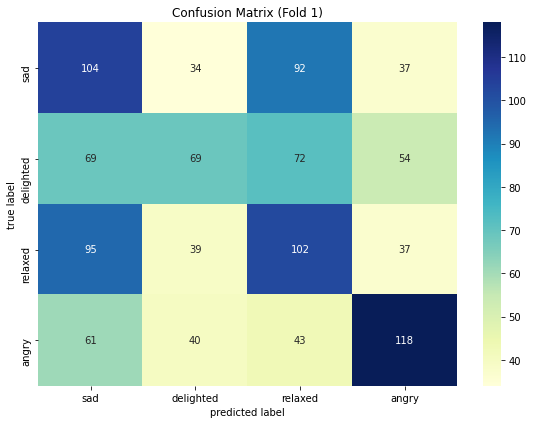

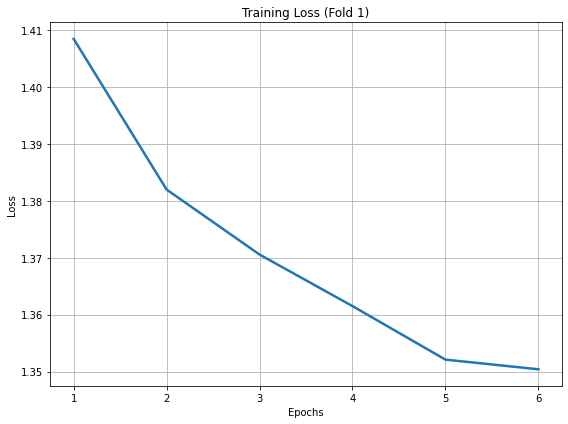

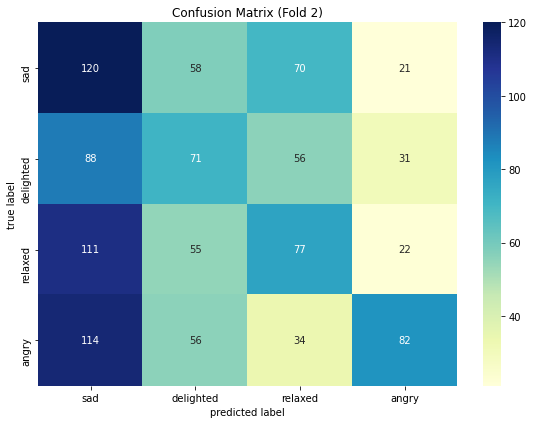

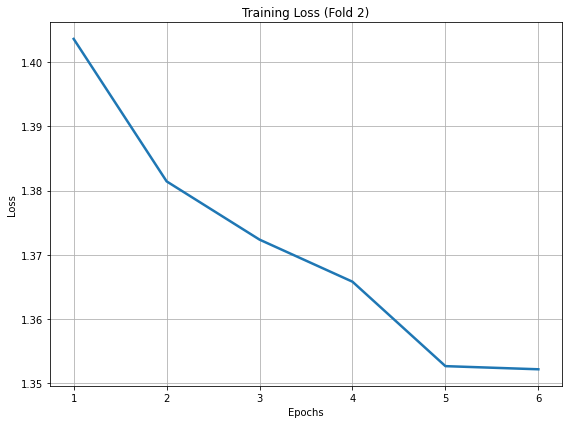

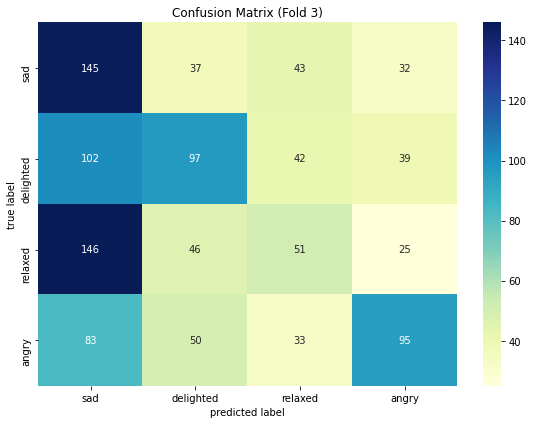

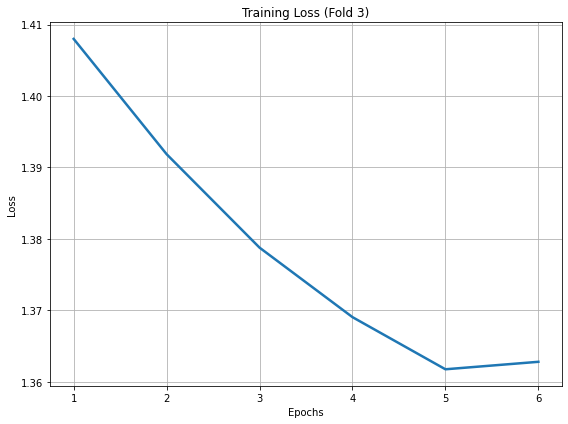

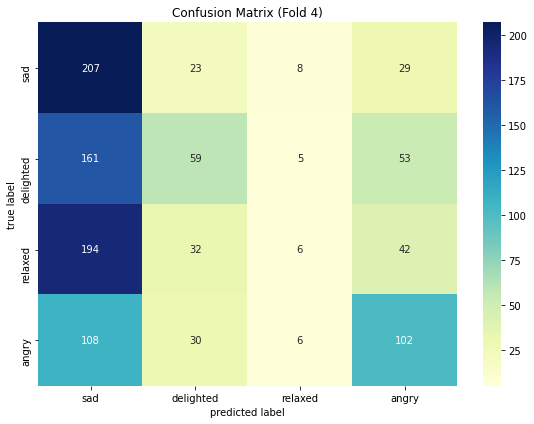

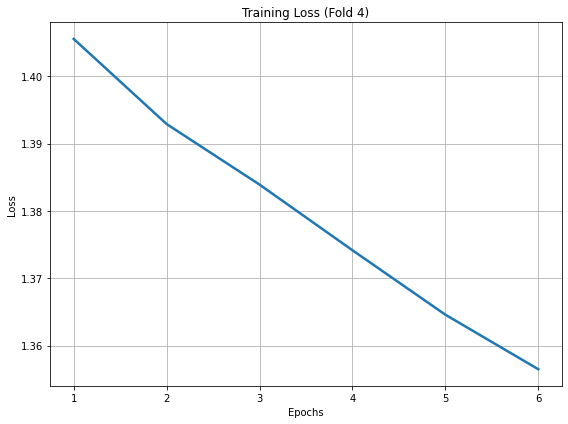

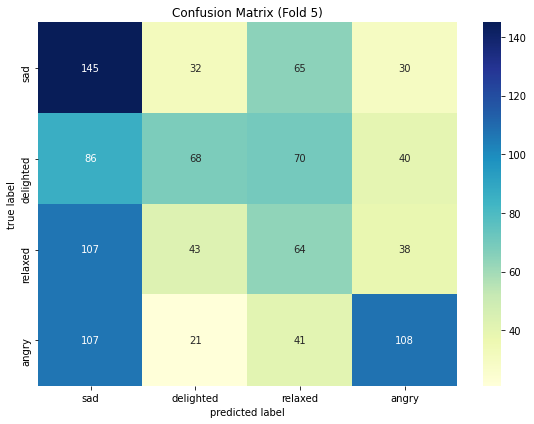

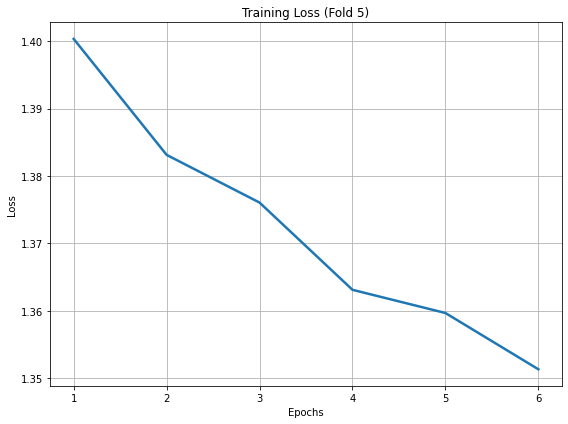

In [ ]:
num_epochs = [2,4,6,8]

for epochs in num_epochs:

  # Create Log File
  LOG = Logger()

  # Connect to google drive
  drive.mount('/content/gdrive')

  device, GPU_name = get_GPU_device()

  # Define parameters for configuration
  config = {"pretrained": True,
            "num_classes": 4,
            "num_folds": 5,
            "epochs": epochs,
            "device": device,
            "test_split": 0.2,
            "learning_rate": 2e-5,
            "scheduler": True,
            "batch_size": 4,
            "random_state": 2021,
            "data_path": '/path/to/combined_dataset.pkl', # Change in order to run the script 
            "saved_models_path":'/path/to/saved/models', # Change in order to run the script
            "save_model": False,
            "save_metrics": True}

  config["case"] = "TL{}_3x224x224_MAXLEN_160".format(config["epochs"])

  data = load_pkl_data(config["data_path"])

  # Prepare data for cross-validation
  data = create_kfold_CV(data=data,num_folds=config["num_folds"],random_state=config["random_state"],shuffle=True)

  LOG.add("Run Name","FULL RUN.")
  LOG.add("Date/Time",datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S (UTC)"))
  LOG.add("config",config)
  LOG.add("case",config["case"])
  LOG.add("GPU",GPU_name)

  LOG.add("Libraries",'')
  LOG.add("PyTorch version",torch.__version__)
  LOG.add("TensorFlow version",tf.__version__)
  LOG.add("Transformers version",transformers.__version__)
  LOG.add("Sklearn version",sklearn.__version__)
  LOG.add("Numpy version",np.__version__)
  LOG.add("Matplotlib version",matplotlib.__version__)

  accuracy_allfolds = []

  # Create folder for current model
  config["model_folder_name"] = create_model_folder_name(config["case"],config["saved_models_path"])


  t_start = time.time()
  with tqdm(total=config["num_folds"]) as t:
    for fold in range(1,config["num_folds"]+1):
      # Create model
      model = LyricsNet(num_classes=config["num_classes"],pretrained=config["pretrained"]).to(device)
      if fold == 1:
        LOG.add("Model",model)

      train_data,test_data = get_train_val_folds(data,fold)

      accuracy_single_fold = train_eval_LyricsNet(model,device,train_data,test_data,config,logger=LOG,fold=fold,save_model=config["save_model"])

      accuracy_allfolds.append(accuracy_single_fold)

      # Empty CUDA cache after each fold to avoid GPU out-of-memory issues
      torch.cuda.empty_cache()
      print('\nCUDA cache emptied!')

      t.update()

  print('\nMean Accuracy = {:05.3f}'.format(np.mean(accuracy_allfolds)))
  LOG.add('OVERALL ACCURACY','\n{:=^60}'.format(''))
  LOG.add('Accuracy All Folds',accuracy_allfolds)
  LOG.add('Mean Accuracy','{:05.3f} %'.format(np.mean(accuracy_allfolds)))

  t_end = time.time()
  t_elapsed = t_end - t_start
  LOG.add('Total Execution Time','{:05.2f} minutes'.format(t_elapsed/60))

  # Save Log File to Google Drive
  if config["save_metrics"]:
    path = config["saved_models_path"]+config["model_folder_name"]+'/'
    LOG.save_log(path)

# Create LyricsNetRW (Random Weights)

Train and evalute the LyricsNet with not Transfer Learning (weights are randomly initialised).

In [ ]:
num_epochs = [2,4,6,8]

for epochs in num_epochs:

  # Create Log File
  LOG = Logger()

  # Connect to google drive
  drive.mount('/content/gdrive')

  device, GPU_name = get_GPU_device()

  # Define parameters for configuration
  config = {"pretrained": False,
            "num_classes": 4,
            "num_folds": 5,
            "epochs": epochs,
            "device": device,
            "test_split": 0.2,
            "learning_rate": 2e-5,
            "scheduler": True,
            "batch_size": 4,
            "random_state": 2021,
            "data_path": '/path/to/combined_dataset.pkl', # Change in order to run the script 
            "saved_models_path":'/path/to/saved/models', # Change in order to run the script
            "save_model": False,
            "save_metrics": True}

  config["case"] = "RW{}_3x224x224_MAXLEN_160".format(config["epochs"])

  data = load_pkl_data(config["data_path"])

  # Prepare data for cross-validation
  data = create_kfold_CV(data=data,num_folds=config["num_folds"],random_state=config["random_state"],shuffle=True)

  LOG.add("Run Name","FULL RUN.")
  LOG.add("Date/Time",datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S (UTC)"))
  LOG.add("config",config)
  LOG.add("case",config["case"])
  LOG.add("GPU",GPU_name)

  LOG.add("Libraries",'')
  LOG.add("PyTorch version",torch.__version__)
  LOG.add("TensorFlow version",tf.__version__)
  LOG.add("Transformers version",transformers.__version__)
  LOG.add("Sklearn version",sklearn.__version__)
  LOG.add("Numpy version",np.__version__)
  LOG.add("Matplotlib version",matplotlib.__version__)

  accuracy_allfolds = []

  # Create folder for current model
  config["model_folder_name"] = create_model_folder_name(config["case"],config["saved_models_path"])


  t_start = time.time()
  with tqdm(total=config["num_folds"]) as t:
    for fold in range(1,config["num_folds"]+1):
      # Create model
      model = LyricsNet(num_classes=config["num_classes"],pretrained=config["pretrained"]).to(device)
      if fold == 1:
        LOG.add("Model",model)

      train_data,test_data = get_train_val_folds(data,fold)

      accuracy_single_fold = train_eval_LyricsNet(model,device,train_data,test_data,config,logger=LOG,fold=fold,save_model=config["save_model"])

      accuracy_allfolds.append(accuracy_single_fold)

      # Empty CUDA cache after each fold to avoid GPU out-of-memory issues
      torch.cuda.empty_cache()
      print('\nCUDA cache emptied!')

      t.update()

  print('\nMean Accuracy = {:05.3f}'.format(np.mean(accuracy_allfolds)))
  LOG.add('OVERALL ACCURACY','\n{:=^60}'.format(''))
  LOG.add('Accuracy All Folds',accuracy_allfolds)
  LOG.add('Mean Accuracy','{:05.3f} %'.format(np.mean(accuracy_allfolds)))

  t_end = time.time()
  t_elapsed = t_end - t_start
  LOG.add('Total Execution Time','{:05.2f} minutes'.format(t_elapsed/60))

  # Save Log File to Google Drive
  if config["save_metrics"]:
    path = config["saved_models_path"]+config["model_folder_name"]+'/'
    LOG.save_log(path)